In [1]:
# libraries
import xport ## Python reader for .XPT files

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# 1. raw data - column selection, drop na and merge

In [2]:
# Function: reads XPT data file and extracts columns of interest
def read_extract_XPT(file, cols):
    '''Takes file name and columns of interest and returns a dataframe of interest.
       Input: file - a string of file name.
              cols - a list of strings of column names.
       Output: df - a pd.DataFrame.'''
    with open(file, 'rb') as f:
        df = xport.to_dataframe(f)
    df = df[cols]
    return df

# directory of all raw data files
dir_raw = "data_NHANES/" 

In [3]:
# Retrieves X regressors
x_demo = read_extract_XPT(dir_raw+"DEMO_D.XPT", ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDEDUC2']).dropna()
x_demo = x_demo[x_demo['RIDAGEYR']>=20]  ## filters participants whose age>=20
x_demo = x_demo[(x_demo['DMDEDUC2']!=7)&(x_demo['DMDEDUC2']!=9)]  ## filters 7'Refused' and 9'Don't Know'
### indicator relabel: 0<-"2"(female)
x_demo.loc[x_demo['RIAGENDR'] == 2, 'RIAGENDR'] = 0
x_demo = x_demo.rename(columns={"RIAGENDR": "gender", "RIDAGEYR": "age", "RIDRETH1": "race", "DMDEDUC2": "education"})

x_health = read_extract_XPT(dir_raw+"HIQ_D.XPT", ['SEQN', 'HIQ011']).dropna()
x_health = x_health[(x_health['HIQ011']!=7)&(x_health['HIQ011']!=9)]  ## filters 7'Refused' and 9'Don't Know'
x_health.loc[x_health['HIQ011'] == 2, 'HIQ011'] = 0  ## indicator relabel: 0<-"2"(no)
x_health = x_health.rename(columns={"HIQ011": "health_insur"})


# Merges all x variables together
x = x_demo.merge(x_health)
x.head()

,SEQN,gender,age,race,education,health_insur
0,31130.0,0.0,85.0,3.0,4.0,1.0
1,31131.0,0.0,44.0,4.0,4.0,1.0
2,31132.0,1.0,70.0,3.0,5.0,1.0
3,31134.0,1.0,73.0,3.0,3.0,1.0
4,31136.0,0.0,41.0,4.0,4.0,1.0


In [4]:
# Retrieves y factors
## smoking
y_smoke = read_extract_XPT(dir_raw+"SMQ_D.XPT", ['SEQN', 'SMQ020']).dropna()
y_smoke = y_smoke[(y_smoke['SMQ020']!=7)&(y_smoke['SMQ020']!=9)]  ## filters 7'Refused' and 9'Don't Know'
### indicator relabel: 0<-"1"(yes), 1<-"2"(no)
y_smoke.loc[y_smoke['SMQ020'] == 1, 'SMQ020'] = 0
y_smoke.loc[y_smoke['SMQ020'] == 2, 'SMQ020'] = 1
y_smoke = y_smoke.rename(columns={"SMQ020": "smoking"})

## BMI
y_BMI = read_extract_XPT(dir_raw+"BMX_D.XPT", ['SEQN', 'BMXBMI']).dropna()
### indicator setup: 1 if BMI in [18.5, 24.9] while 0 otherwise
y_BMI.loc[(y_BMI['BMXBMI']>=18.5) & (y_BMI['BMXBMI']<=24.9), 'BMI'] = 1
y_BMI.loc[(y_BMI['BMXBMI']<18.5) | (y_BMI['BMXBMI']>24.9), 'BMI'] = 0
y_BMI = y_BMI[['SEQN', 'BMI']]

## physical activity
y_phy_ac = read_extract_XPT(dir_raw+"PAQIAF_D.XPT", ['SEQN', 'PADLEVEL', 'PADTIMES', 'PADDURAT']).dropna()
### indicator setup: 1 if total activity time >= 600 while 0 otherwise
y_phy_ac['tot'] = y_phy_ac['PADLEVEL'] * y_phy_ac['PADTIMES'] * y_phy_ac['PADDURAT']
y_phy_ac = y_phy_ac.groupby('SEQN', as_index = False).agg('sum')
y_phy_ac['phy_ac'] = (y_phy_ac['tot']>=600).map(int)
y_phy_ac = y_phy_ac[['SEQN', 'phy_ac']]

## diet
y_diet = read_extract_XPT(dir_raw+"DBQ_D.XPT", ['SEQN', 'DBQ700']).dropna()
y_diet = y_diet[(y_diet['DBQ700']!=7)&(y_diet['DBQ700']!=9)]  ## filters 7'Refused' and 9'Don't Know'
### indicator setup: 1 if diet is 1(excellent), 2(very good), 3(good) while 0 if 4(fair), 5(poor)
y_diet.loc[y_diet['DBQ700'].isin([1,2,3]), 'DBQ700'] = 1
y_diet.loc[y_diet['DBQ700'].isin([4,5]), 'DBQ700'] = 0
y_diet = y_diet.rename(columns={"DBQ700": "diet"})

## blood cholesterol
y_BC = read_extract_XPT(dir_raw+"TCHOL_D.XPT", ['SEQN', 'LBXTC']).dropna()
### indicator setup: 1 if blood cholesterol < 200 while 0 if blood cholesterol >= 200
y_BC.loc[y_BC['LBXTC']<200, 'LBXTC'] = 1
y_BC.loc[y_BC['LBXTC']>=200, 'LBXTC'] = 0
y_BC = y_BC.rename(columns={"LBXTC": "blood_chol"})

## blood glucose
y_BG = read_extract_XPT(dir_raw+"GLU_D.XPT", ['SEQN', 'LBXGLU']).dropna()
### indicator setup: 1 if blood glucose <= 100 while 0 if blood glucose > 100
y_BG.loc[y_BG['LBXGLU']<=100, 'LBXGLU'] = 1
y_BG.loc[y_BG['LBXGLU']>100, 'LBXGLU'] = 0
y_BG = y_BG.rename(columns={"LBXGLU": "blood_gluc"})

## blood pressure
y_BP = read_extract_XPT(dir_raw+"BPX_D.XPT", ['SEQN', 'BPXSY1', 'BPXDI1', 'BPXSY2', 'BPXDI2', 'BPXSY3', 'BPXDI3'])
### indicator setup: 1 if both average systolic<120 and average diastolic<80 while 0 if one does not apply
y_BP['avg_syst'] = np.nanmean(y_BP[['BPXSY1','BPXSY2','BPXSY3']], axis=1)
y_BP['avg_dias'] = np.nanmean(y_BP[['BPXDI1', 'BPXDI2', 'BPXDI3']], axis=1)
#y_BP = y_BP[(y_BP['avg_syst']!=0) & (y_BP['avg_dias']!=0)]
y_BP = y_BP[['SEQN', 'avg_syst', 'avg_dias']].dropna()
y_BP['blood_pres'] = ((y_BP['avg_syst']<120) & (y_BP['avg_dias']<80)).map(int)
y_BP = y_BP[['SEQN', 'blood_pres']]


# Merges all y variables together
y = y_smoke.merge(y_BMI).merge(y_phy_ac).merge(y_diet).merge(y_BC).merge(y_BG).merge(y_BP)
y.head()

,SEQN,smoking,BMI,phy_ac,diet,blood_chol,blood_gluc,blood_pres
0,31132.0,1.0,1.0,1,1.0,1.0,0.0,0
1,31134.0,1.0,0.0,0,1.0,1.0,1.0,0
2,31150.0,0.0,0.0,1,0.0,1.0,1.0,0
3,31153.0,0.0,0.0,1,1.0,1.0,1.0,0
4,31155.0,1.0,0.0,1,1.0,1.0,1.0,0


In [5]:
## merge all variables (X,y) together
df = x.merge(y)
df.head()

,SEQN,gender,age,race,education,health_insur,smoking,BMI,phy_ac,diet,blood_chol,blood_gluc,blood_pres
0,31132.0,1.0,70.0,3.0,5.0,1.0,1.0,1.0,1,1.0,1.0,0.0,0
1,31134.0,1.0,73.0,3.0,3.0,1.0,1.0,0.0,0,1.0,1.0,1.0,0
2,31150.0,1.0,79.0,3.0,3.0,1.0,0.0,0.0,1,0.0,1.0,1.0,0
3,31153.0,0.0,44.0,5.0,3.0,1.0,0.0,0.0,1,1.0,1.0,1.0,0
4,31155.0,1.0,38.0,5.0,5.0,1.0,1.0,0.0,1,1.0,1.0,1.0,0


In [6]:
df.shape

(1261, 13)

# 2. data visualization

# 3. indicator-by-indicator logistic regression

In [7]:
import statsmodels.api as sm

df.exog = sm.add_constant(df[["gender", "age", "race", "education", "health_insur"]])
y_cols = ['smoking', 'BMI', 'phy_ac', 'diet', 'blood_chol', 'blood_gluc', 'blood_pres']
params = []; pvalues = []
for col in y_cols:
    glm = sm.GLM(df[col], df.exog,  
                 family = sm.families.Binomial()).fit()
    #print(glm.summary())
    params.append(glm.params['gender'])
    pvalues.append(glm.pvalues['gender'])

In [8]:
single_logit = pd.DataFrame(data = {'Coeffcient': params, 'p-value': pvalues},
                            index = y_cols)
single_logit['significance'] = single_logit['p-value']<=0.05
single_logit

,Coeffcient,p-value,significance
smoking,-0.660910,1.397150e-08,True
BMI,-0.143427,2.518903e-01,False
phy_ac,0.435534,2.757252e-04,True
diet,0.041502,7.622967e-01,False
blood_chol,0.219352,5.656795e-02,False
blood_gluc,-0.722528,1.821643e-08,True
blood_pres,-0.896554,4.626274e-13,True


# 4. regress on response - CVH

In [9]:
df['CVH'] = df.loc[:, y_cols].sum(axis=1)
df.head()

,SEQN,gender,age,race,education,health_insur,smoking,BMI,phy_ac,diet,blood_chol,blood_gluc,blood_pres,CVH
0,31132.0,1.0,70.0,3.0,5.0,1.0,1.0,1.0,1,1.0,1.0,0.0,0,5.0
1,31134.0,1.0,73.0,3.0,3.0,1.0,1.0,0.0,0,1.0,1.0,1.0,0,4.0
2,31150.0,1.0,79.0,3.0,3.0,1.0,0.0,0.0,1,0.0,1.0,1.0,0,3.0
3,31153.0,0.0,44.0,5.0,3.0,1.0,0.0,0.0,1,1.0,1.0,1.0,0,4.0
4,31155.0,1.0,38.0,5.0,5.0,1.0,1.0,0.0,1,1.0,1.0,1.0,0,5.0


## 4.1 OLS

In [10]:
# basic OLS
ols = sm.OLS.from_formula(formula = 'CVH ~ gender + age + race + education + health_insur', data = df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    CVH   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     39.72
Date:                Wed, 04 Dec 2019   Prob (F-statistic):           5.60e-38
Time:                        10:01:04   Log-Likelihood:                -2152.9
No. Observations:                1261   AIC:                             4318.
Df Residuals:                    1255   BIC:                             4349.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.3490      0.187     23.269   

In [11]:
# OLS with simple backward elimination - deletes 'race'
ols = sm.OLS.from_formula(formula = 'CVH ~ gender + age + education + health_insur', data = df).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    CVH   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     49.68
Date:                Wed, 04 Dec 2019   Prob (F-statistic):           7.50e-39
Time:                        10:01:04   Log-Likelihood:                -2152.9
No. Observations:                1261   AIC:                             4316.
Df Residuals:                    1256   BIC:                             4341.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.3381      0.170     25.526   

## 4.2 Boxplot

In [12]:
df['age_decades'] = df['age']//10
df.head()

,SEQN,gender,age,race,education,health_insur,smoking,BMI,phy_ac,diet,blood_chol,blood_gluc,blood_pres,CVH,age_decades
0,31132.0,1.0,70.0,3.0,5.0,1.0,1.0,1.0,1,1.0,1.0,0.0,0,5.0,7.0
1,31134.0,1.0,73.0,3.0,3.0,1.0,1.0,0.0,0,1.0,1.0,1.0,0,4.0,7.0
2,31150.0,1.0,79.0,3.0,3.0,1.0,0.0,0.0,1,0.0,1.0,1.0,0,3.0,7.0
3,31153.0,0.0,44.0,5.0,3.0,1.0,0.0,0.0,1,1.0,1.0,1.0,0,4.0,4.0
4,31155.0,1.0,38.0,5.0,5.0,1.0,1.0,0.0,1,1.0,1.0,1.0,0,5.0,3.0


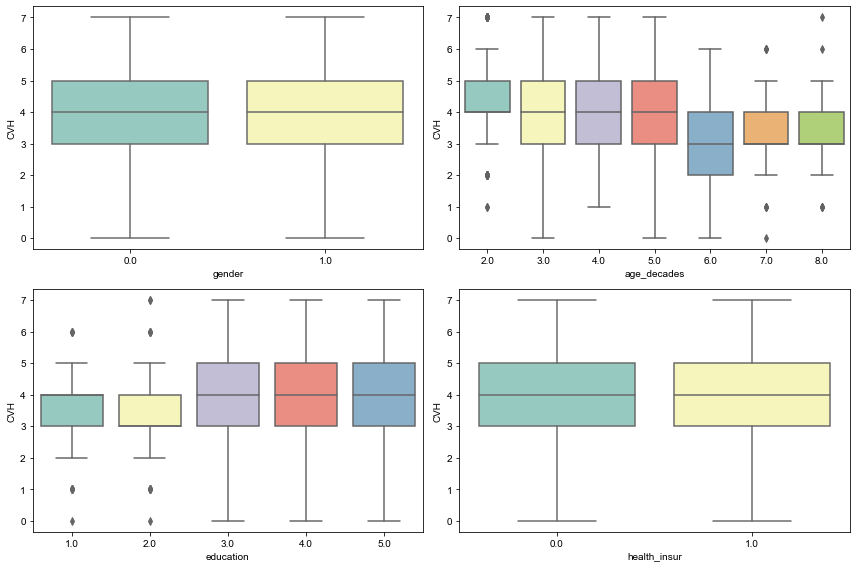

In [13]:
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

# Create a figure with four subplots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# Draw group boxplots
import seaborn as sns
sns.set_style("whitegrid")

sns.boxplot(x="gender", y="CVH", data=df, palette="Set3", ax=ax1)
sns.boxplot(x="age_decades", y="CVH", data=df, palette="Set3", ax=ax2)
sns.boxplot(x="education", y="CVH", data=df, palette="Set3", ax=ax3)
sns.boxplot(x="health_insur", y="CVH", data=df, palette="Set3", ax=ax4)

# Show plots
plt.tight_layout()
plt.show()

## 4.3 mixed effects

In [14]:
df["group"] = 1                                                                                                            

vcf = {"age_decades": "0 + C(age_decades)", "education": "0 + C(education)"}                                                         
mixedlm = sm.MixedLM.from_formula("CVH ~ gender + health_insur", groups="group",                                                    
                                vc_formula=vcf, re_formula="0", data=df).fit()                                                 
print(mixedlm.summary())

          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: CVH       
No. Observations:   1261    Method:             REML      
No. Groups:         1       Scale:              1.7495    
Min. group size:    1261    Likelihood:         -2159.5526
Max. group size:    1261    Converged:          Yes       
Mean group size:    1261.0                                
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        3.709    0.238 15.565 0.000  3.242  4.176
gender          -0.379    0.075 -5.021 0.000 -0.526 -0.231
health_insur     0.191    0.102  1.876 0.061 -0.009  0.390
age_decades Var  0.205    0.094                           
education Var    0.082    0.048                           

